# 手寫阿拉伯數字辨識 正規化

## 載入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 設定參數

In [2]:
PATH_DATASETS = "std" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    ])


# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transform)

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transform)

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [4]:
# 訓練資料前10筆圖片的數字
train_ds.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [5]:
# 顯示第1張圖片內含值
train_ds.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [6]:
# 將非0的數字轉為1，顯示第1張圖片
data = train_ds.data[0].clone()
data = data.numpy()
data[data>0]=1
data = data.astype(int)

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000001111111111110000',
 '0000000011111111111111110000',
 '0000000111111111111111100000',
 '0000000111111111110000000000',
 '0000000011111110110000000000',
 '0000000001111100000000000000',
 '0000000000011110000000000000',
 '0000000000011110000000000000',
 '0000000000001111110000000000',
 '0000000000000111111000000000',
 '0000000000000011111100000000',
 '0000000000000001111100000000',
 '0000000000000000011110000000',
 '0000000000000011111110000000',
 '0000000000001111111100000000',
 '0000000000111111111000000000',
 '0000000011111111110000000000',
 '0000001111111111000000000000',
 '0000111111111100000000000000',
 '0000111111110000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [7]:
# 將非0的數字轉為1，顯示第2張圖片
data = train_ds.data[1].clone()
data = data.numpy()
data[data>0]=1
data = data.astype(int)

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000001111100000000',
 '0000000000000011111100000000',
 '0000000000000111111111000000',
 '0000000000011111111111000000',
 '0000000000011111111111000000',
 '0000000000111111111111000000',
 '0000000001111111110011100000',
 '0000000011111100000011100000',
 '0000000111111100000011100000',
 '0000000111100000000011100000',
 '0000000111000000000011100000',
 '0000001111000000000011100000',
 '0000001111000000001111100000',
 '0000001110000000011111000000',
 '0000001110000000111100000000',
 '0000001110000001111000000000',
 '0000001111111111111000000000',
 '0000001111111111100000000000',
 '0000001111111110000000000000',
 '0000000111111100000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

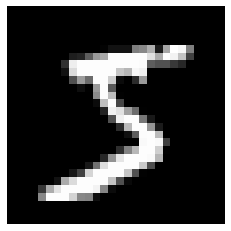

In [8]:
# 顯示第1張圖片圖像
import matplotlib.pyplot as plt

# 第一筆資料
X = train_ds.data[0]

# 繪製點陣圖，cmap='gray':灰階
plt.imshow(X.reshape(28,28), cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

## 步驟2：資料清理，此步驟無需進行

## 步驟3：進行特徵工程，將特徵縮放成(0, 1)之間

In [9]:
# 正規化
train_ds.data = train_ds.data / 255.0
test_ds.data = test_ds.data / 255.0

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [10]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 256), 
    nn.Dropout(0.2),
    torch.nn.Linear(256, 10), 
    # 使用nn.CrossEntropyLoss()時，不需要將輸出經過softmax層，否則計算的損失會有誤
    #torch.nn.Softmax(dim=1)
).to(device)

## 步驟6：結合訓練資料及模型，進行模型訓練

In [11]:
epochs = 5
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 設定優化器(optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        # loss = nn.functional.nll_loss(output, target) 
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %)  Loss: 2.320893
Epoch 1: [ 6000 / 60000] (10 %)  Loss: 21.058321
Epoch 1: [12000 / 60000] (20 %)  Loss: 14.615396
Epoch 1: [18000 / 60000] (30 %)  Loss: 7.272960
Epoch 1: [24000 / 60000] (40 %)  Loss: 5.849614
Epoch 1: [30000 / 60000] (50 %)  Loss: 4.201842
Epoch 1: [36000 / 60000] (60 %)  Loss: 2.784539
Epoch 1: [42000 / 60000] (70 %)  Loss: 1.921148
Epoch 1: [48000 / 60000] (80 %)  Loss: 1.669999
Epoch 1: [54000 / 60000] (90 %)  Loss: 1.642164
Epoch 2: [    0 / 60000] (0 %)  Loss: 1.864826
Epoch 2: [ 6000 / 60000] (10 %)  Loss: 1.626204
Epoch 2: [12000 / 60000] (20 %)  Loss: 1.590835
Epoch 2: [18000 / 60000] (30 %)  Loss: 1.563107
Epoch 2: [24000 / 60000] (40 %)  Loss: 1.688237
Epoch 2: [30000 / 60000] (50 %)  Loss: 1.773960
Epoch 2: [36000 / 60000] (60 %)  Loss: 1.582444
Epoch 2: [42000 / 60000] (70 %)  Loss: 1.694004
Epoch 2: [48000 / 60000] (80 %)  Loss: 1.505382
Epoch 2: [54000 / 60000] (90 %)  Loss: 1.596213
Epoch 3: [    0 / 60000] (0 %)  Loss: 1.

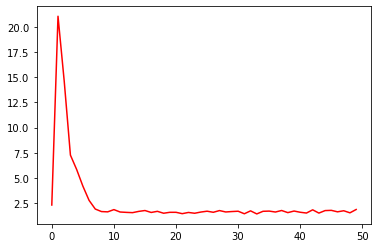

In [12]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [13]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # test_loss += nn.functional.nll_loss(output, target).item()
        
        # 預測
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正確筆數
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均損失
data_count = len(test_loader.dataset)
test_loss /= data_count
# 顯示測試結果
percentage = 100. * correct / data_count
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均損失: 1.8549, 準確率: 4569/10000 (46%)



In [14]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 7 0 2 7 8 1 6 9 7 2 4


In [15]:
# 顯示第 9 筆的機率
import numpy as np

i=8
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
#print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9預測機率: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9預測機率: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

0~9預測機率: [[0.   0.   0.   0.   0.03 0.97 0.   0.   0.   0.  ]]
0~9預測機率: [5]


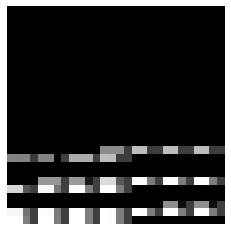

In [16]:
# 顯示第 9 筆圖像
X2 = test_ds[i][0] 
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

## 步驟10：新資料預測

In [31]:
# 使用小畫家，繪製 0~9，實際測試看看
from PIL import Image
from skimage.transform import resize
import numpy as np

# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = Image.open(uploaded_file).convert('L')

    # 縮為 (28, 28) 大小的影像
    image_resized = np.asarray(image1.resize((28, 28)))
    X1 = image_resized.reshape(1,28, 28) / 255.0

    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = torch.FloatTensor(1-X1).to(device)

    # 預測
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 6
actual/prediction: 1 6
actual/prediction: 2 6
actual/prediction: 3 6
actual/prediction: 4 6
actual/prediction: 5 6
actual/prediction: 6 6
actual/prediction: 7 6
actual/prediction: 8 6
actual/prediction: 9 6


In [32]:
X1

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.1333, 0.5882, 0.6353, 0.6353, 0.6353, 0.5216, 0.1765, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

## 使用 DataLoader

In [18]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import re

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = [file_name for file_name in os.listdir(img_dir)]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 組合檔案完整路徑
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        # 讀取圖檔
        image = read_image(img_path)
        if image.shape[0]>3:
            image = image[1:,:,:]
        # 去除副檔名
        label = self.img_labels[idx].split('.')[0]
        label = int(label)
        
        # 轉換
        # print(type(image))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        # 將三維轉為二維
        image = image.reshape(*image.shape[1:])
        # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
        image = 1.0-image
        
        return image, label

In [19]:
# 建立 transforms
transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.CenterCrop(28),
    transforms.ConvertImageDtype(torch.float),
])

# 建立 DataLoader
test_loader = DataLoader(CustomImageDataset('./myDigits', transform)
                         , shuffle=False, batch_size=10)

model.eval()
criterion = nn.CrossEntropyLoss()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        
        # 預測
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正確筆數
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均損失
test_loss /= len(test_loader.dataset)
# 顯示測試結果
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均損失: 4.0483, 準確率: 1/10 (10%)

